In [1]:
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum

from IPython.display import clear_output
clear_output()

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/Projects/GSoC 2021'

/content/drive/.shortcut-targets-by-id/1PiGZPRwtvmwxh1Xs0mtaS05Kvo_tnftz/GSoC 2021


# Task III: Quantum Convolutional Neural Network (QCNN) Part

Problem statement: Setup and apply a quantum convolutional neural network (QCNN) on particle physics data to perform binary classification on two types of objects (electrons and photons) using TFQ. Feel free to experiment with different ways of encoding the classical data inputs into the qubits. Specifically, show that the model fits the dataset and that your training loss decreases over time (given the small dataset size, we will not be focusing on the accuracy of your model).

## The Approach Used to Tackle the Problem

### Dataset & Preprocessing

The dataset consists of 100 samples, both for the training set and testing set. The label consists of two classes, photons are labeled 0, and electrons are labeled 1. Every sample is a 32 x 32 image containing the particle's energy. This means every sample has 32 x 32 = 1024 features if we consider every pixel in the image as a feature. This number is clearly too big if we naively use 1 qubit for every feature. Some feature reduction technique is needed. The maximum number of qubits allowed in Cirq is about 20 qubits.

Since the image is very sparse (a lot of pixels with zero values), the one thing that immediately comes to mind is to crop the image, cutting all zero pixels on the image's border. But after some further inspections, there are some images with non-zero pixels near the border of the image. Cropping the image will make the data lose some of (maybe) important features. Another method that comes to mind is to do max or average-pooling on the image. But once again, since the image is sparse, there is a very high chance that two very different 32 x 32 images will look the same after pooling. Not only that, the image after pooling will lose a lot of detail, making it harder for the model to differentiate it.

Many previous works have tried to classify image data using a parametrized quantum circuit (PQC), mostly MNIST dataset[1]. In almost all of them, the authors suggested a way to reduce the image dimension. In reference [2] (and its [code implementation](https://www.tensorflow.org/quantum/tutorials/mnist)), the author tried to reduce the image dimension by using bilinear interpolation. This method has a similar problem with pooling. There is a very high chance that two different images (even with a different label) will look the same after the reduction. This indeed happened and is mentioned in the paper.

The other seemingly famous and reasonable approach is by using Principal Component Analysis (PCA). This has been done before with relatively successful results[3-4]. One weakness of this approach in our case is that the PCA model fitted to the training dataset may not be able to catch the true variance of the data distribution since the number of samples in the dataset is small. If we then use this PCA model to transform the testing dataset, the PQC may not classify this data correctly. This problem is similar to overfitting, which also very likely to happen because of the low number of training samples. But because the problem statement also indirectly admitted that overfitting is inevitable with this dataset size, we will ignore the testing performance and go on with PCA.

### Encoding

After the dataset is transformed with PCA, the resulting data will then be transformed into quantum data. There are many ways to do this, and it is not trivial to determine which will give the best result. So in this project, two methods will be tried:

1. Angle Encoding <br>
This method is as simple as treating every feature of the sample as an angle argument for a one-qubit rotation gate that acts on a qubit. In this project, RY gate will be used. Using this encoding, a feature vectors of a sample $\boldsymbol{x}=\left[\begin{array}{llll}
x^{1} & x^{2} & \ldots & x^{N}
\end{array}\right]$ will be transformed to
$$
|\boldsymbol{x}\rangle=R Y\left(x^{1}\right) \otimes R Y\left(x^{2}\right) \otimes \ldots \otimes R Y\left(x^{N}\right) \underbrace{|00 \ldots 00\rangle}_{N} .
$$
where $N$ is the number of features in the sample and $x^{i}$ means the $i$-th feature of $\boldsymbol{x}$. **Figure 1** shows the circuit schematic of this encoding.

2. Amplitude Encoding <br>
This method encodes all features in a sample as amplitudes of a quantum state. The main benefit of this method is it requires less number of qubits. The whole 32 x 32 = 1024 pixels of an image only need $\operatorname{log_{2}}(1024)=10$ qubits. Using this encoding, a feature vectors of a sample $\boldsymbol{x}=\left[\begin{array}{llll}
x^{1} & x^{2} & \ldots & x^{N}
\end{array}\right]$ will be transformed to [5-6]
$$
A_{\mathrm{n}}=\frac{x^{n}}{\sqrt{\sum_{n=1}^{N}\left|x^{n}\right|^{2}}} \\
|\boldsymbol{x}\rangle=\sum_{n=1}^{N} A_{n}|\operatorname{binary}(n-1)\rangle
$$
where $N$ is the number of features in the sample and $\operatorname{binary}$ is an operator that converts integer to its binary form. **Figure 2** shows the circuit schematic of this encoding where
$$
\beta_{j}^{g}=2 \arcsin \left(\frac{\sqrt{\sum_{l=1}^{2 g-1}\left|A_{(2 j-1) 2^{g-1}+l}\right|^{2}}}{\sqrt{\sum_{l=1}^{2 g}\left|A_{(j-1) 2^{g}+l}\right|^{2}}}\right).
$$
The code implementation of this encoding is provided below but unfortunately tfq.convert_to_tensor does not support serialization of cirq.ControlledOperation yet (at the time of submission). This encoding needs cirq.ControlledOperation since the encoding uses multi-controlled RY gate. So in this project, this encoding will not be used for training.

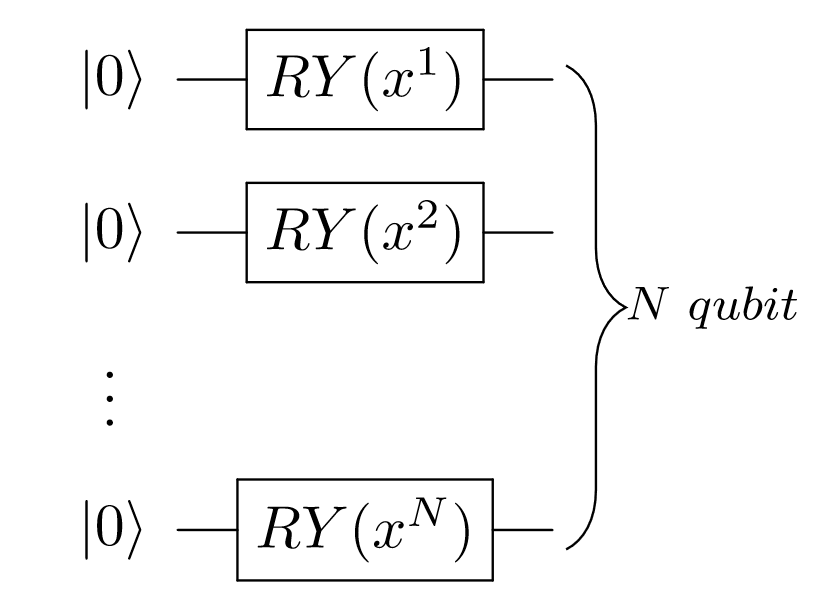

**Figure 1**: Angle encoding.

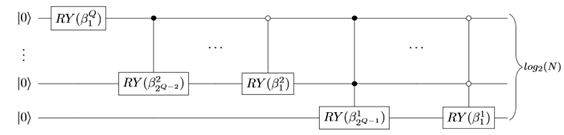

**Figure 2**: Amplitude encoding.

### QCNN Architecture

The QCNN architecture used in this project is similar to the one proposed in its original paper[7]. In the [TFQ tutorial of QCNN](https://www.tensorflow.org/quantum/tutorials/qcnn), the fully connected layer is not implemented though it is mentioned in the paper. This project follows the TFQ tutorial but will implement a PQC as the fully connected layer and compare the performance with the one that does not use it. One layer of this fully connected layer is equal to applying a one-qubit unitary on every qubit used for the layer and CNOT gates that entangled nearby qubits. At the end of the circuit, a final one-qubit unitary gate is applied to the output qubit (the last qubit). The last qubit will then be measured using the Pauli-Z gate, and the result is the prediction output of the model. The complete picture/plot of this fully connected layer will be given in the **Code Implementation** section. **Figure 3** shows the schematic of a QCNN (with a fully connected layer) for 8 data qubits.

Another variation that is also tested in this project is the usage of the cluster state circuit. The QCNN model with and without cluster state circuit will be compared to see whether it gives any improvement to the model's performance or not.

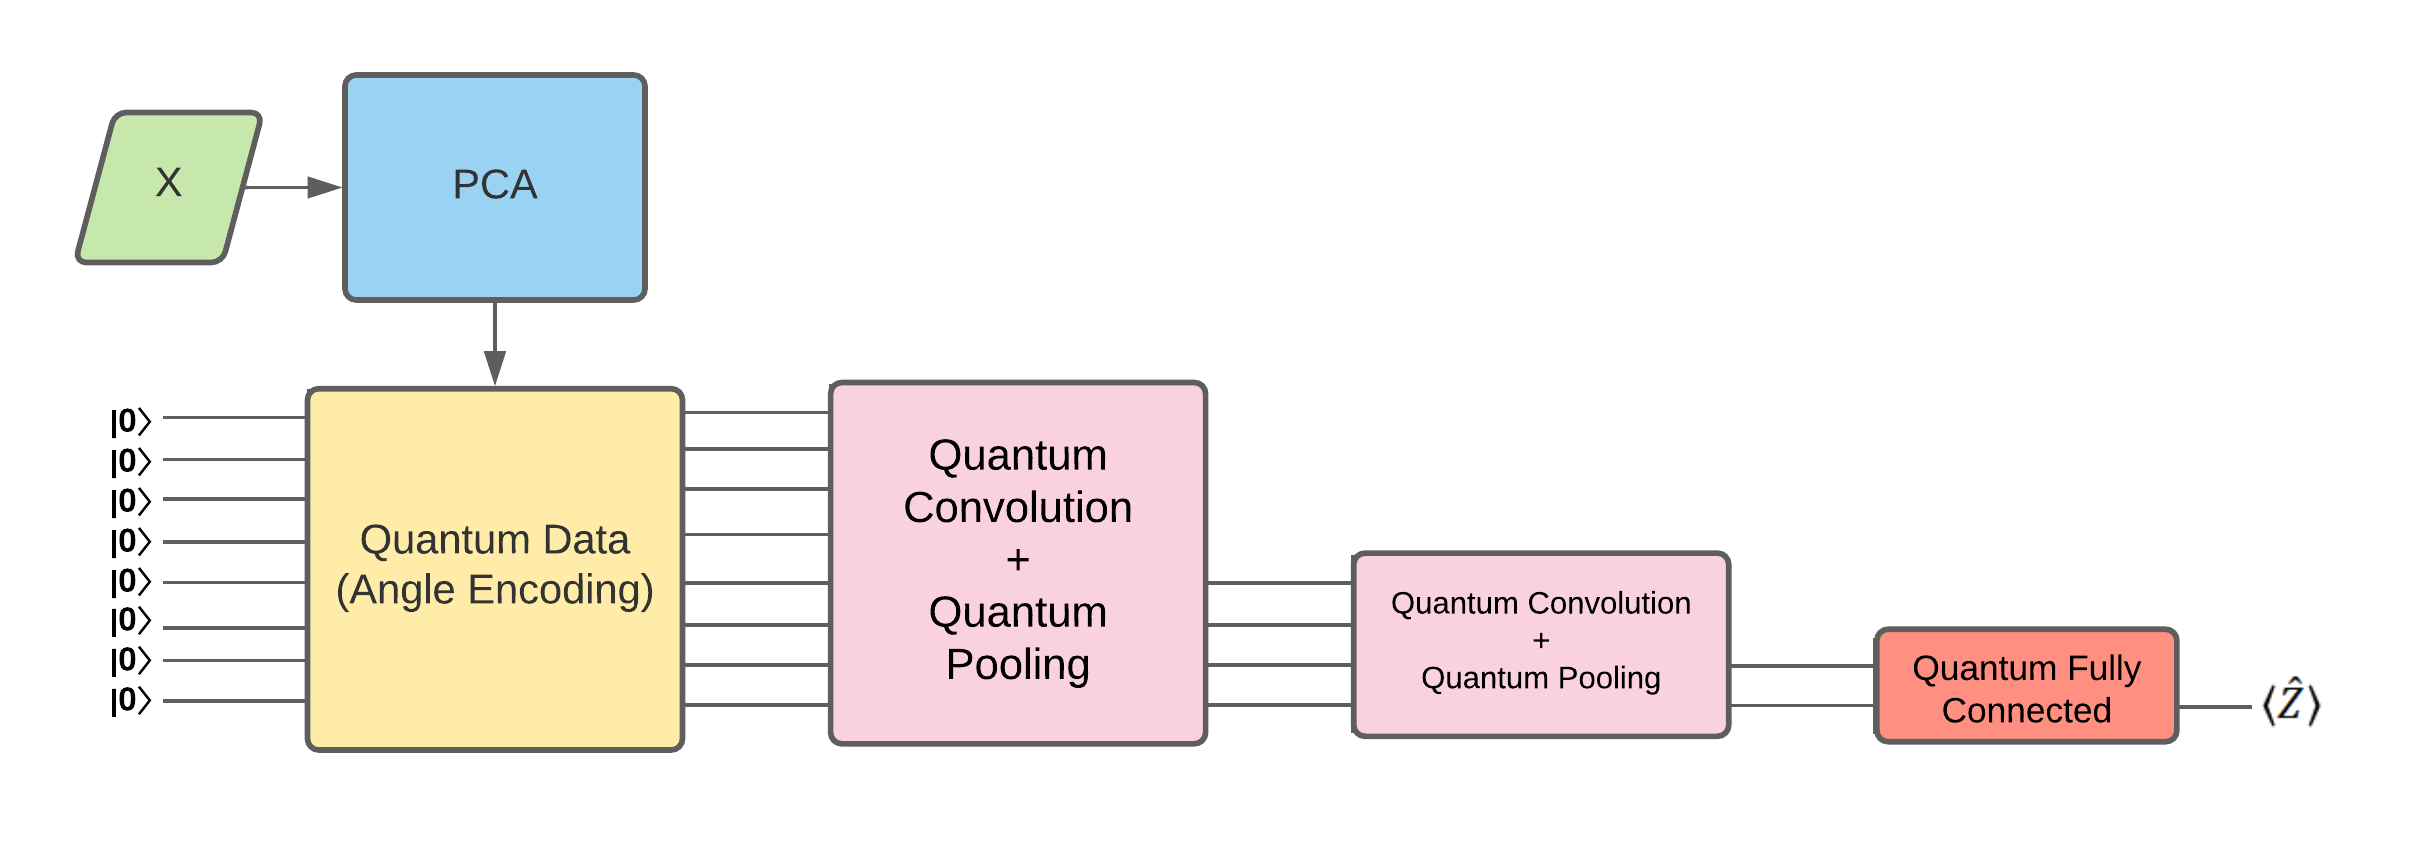

**Figure 3**: The schematic of QCNN (with a fully connected layer).

## Code Implementation

### Load and Check the Dataset

Let's load and check the dataset. We also need to convert the true label to one-hot format but with 1/-1 instead of 1/0 because the expectation value of a Pauli-Z gate is between -1 and 1.

In [5]:
# Load the dataset
with np.load('./electron-photon.npz') as data:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_test = data["x_test"]
    y_test = data["y_test"]

y_train = 2*y_train-1
y_test = 2*y_test-1

# Sanity check
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100, 32, 32) (100,)
(100, 32, 32) (100,)


The next thing to check is the label balances. It turns out that the dataset is quite balanced, so no need to do any dataset imbalance preprocessing tricks, e.g., SMOTE.

In [6]:
# Check class balances
print("Class 0:", (y_train == -1).sum(), "Class 1:", (y_train == 1).sum())
print("Class 0:", (y_test == -1).sum(), "Class 1:", (y_test == 1).sum())

Class 0: 44 Class 1: 56
Class 0: 54 Class 1: 46


Let's plot a sample of images from both labels to see how the images look like.

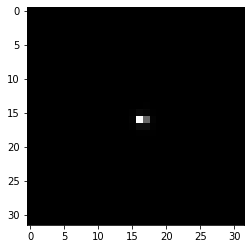

In [7]:
# Plot the image from both classes
plt.imshow(x_train[y_train==-1][0], cmap='gray')

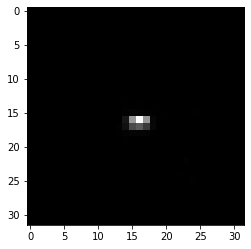

In [8]:
plt.imshow(x_train[y_train==1][0], cmap='gray')

### Testing Out Some Dimensionality Reduction Techniques

First, let's try to find out where is the maximum coordinate of non-zero pixel in the dataset.

In [9]:
# finding the left-most non-zero pixel coordinate in training dataset
for i in range(x_train.shape[2]):
    if x_train[:, :, i].max() != 0:
        border_left = i
        break

# finding the right-most non-zero pixel coordinate in training dataset
for i in range(x_train.shape[2]):
    if x_train[:, :, x_train.shape[2]-1-i].max() != 0:
        border_right = x_train.shape[2]-1-i
        break

# finding the top-most non-zero pixel coordinate in training dataset
for i in range(x_train.shape[1]):
    if x_train[:, i, :].max() != 0:
        border_top = i
        break

# finding the bottom-most non-zero pixel coordinate in training dataset
for i in range(x_train.shape[1]):
    if x_train[:, x_train.shape[1]-1-i, :].max() != 0:
        border_bottom = x_train.shape[1]-1-i
        break

print(border_left, border_right)
print(border_top, border_bottom)

0 29
0 26


In [10]:
# finding the left-most non-zero pixel coordinate in training dataset
for i in range(x_test.shape[2]):
    if x_test[:, :, i].max() != 0:
        border_left = i
        break

# finding the right-most non-zero pixel coordinate in training dataset
for i in range(x_test.shape[2]):
    if x_test[:, :, x_test.shape[2]-1-i].max() != 0:
        border_right = x_test.shape[2]-1-i
        break

# finding the top-most non-zero pixel coordinate in training dataset
for i in range(x_test.shape[1]):
    if x_test[:, i, :].max() != 0:
        border_top = i
        break

# finding the bottom-most non-zero pixel coordinate in training dataset
for i in range(x_test.shape[1]):
    if x_test[:, x_test.shape[1]-1-i, :].max() != 0:
        border_bottom = x_test.shape[1]-1-i
        break

print(border_left, border_right)
print(border_top, border_bottom)

0 29
0 30


Both training and testing datasets have non-zero pixels near the image's very edges, making it impossible to crop the image without information loss.

Second, let's try the max-pooling with filter size 2 x 2 and stride 2 x 2.

In [11]:
def max_pool(image):
  max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
  x = tf.constant(image)
  x = tf.reshape(x, [-1, image.shape[1], image.shape[2], 1])
  return max_pool_2d(x).numpy().reshape(-1, int(x.shape[1]/2), int(x.shape[2]/2))

In [12]:
temp = x_train.copy()
for i in range(3):
    temp = max_pool(temp)
temp.shape

(100, 4, 4)

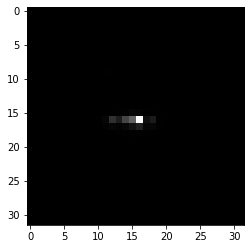

In [13]:
plt.imshow(x_train[56], cmap='gray')

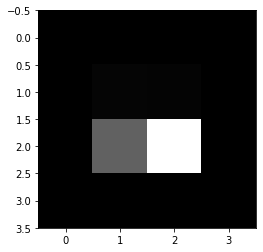

In [14]:
plt.imshow(temp[56], cmap='gray')

We can see that the number of non-zero pixels in an image is reduced greatly after pooling. This is not very good as images will become a lot more similar to one another.

### Define Layers

Next, we need to define all the layers that will be used for the QCNN model.

#### Cluster state

The circuit below is the circuit to prepare a cluster state.

In [62]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

Let's plot the circuit for 4 qubits configuration.

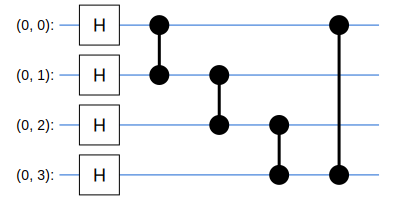

In [63]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

#### Unitaries

Below are the standard, simple, one and two-qubit unitary circuits. These unitaries are generally very useful as building blocks.

In [15]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

#### QCNN Layers

##### Quantum Convolution

This circuit is the Quantum Convolution block in **Figure 3**.

In [16]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits`.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

Let's plot the circuit for 4 qubits configuration.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


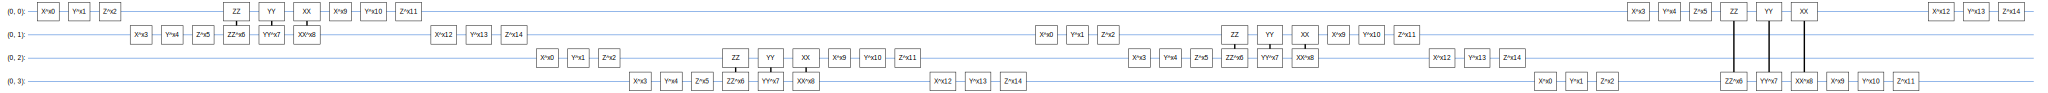

In [17]:
SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, 4), sympy.symbols('x0:15')))

##### Quantum Pooling

This circuit is the Quantum Pooling block in **Figure 3**. If the number of qubits into this circuit is $Q$, this circuit pools the qubits to $\frac{Q}{2}$ qubits.

In [18]:
def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [19]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

Let's plot the circuit for 4 qubits configuration.

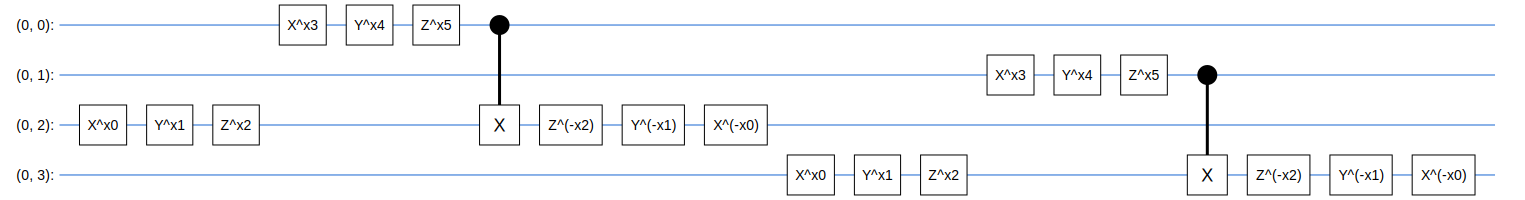

In [20]:
test_bits = cirq.GridQubit.rect(1, 4)
SVGCircuit(quantum_pool_circuit(test_bits[:2], test_bits[2:], sympy.symbols('x0:6')))

##### Quantum Fully Connected

This circuit is the Quantum Fully Connected block in **Figure 3** without the final one-qubit unitary.

In [21]:
def quantum_fc_circuit(bits, symbols):
    """Quantum Fully Connected Layer
    """
    circuit = cirq.Circuit()
    # qubit iteration
    for i in range(len(bits)):
        circuit += one_qubit_unitary(bits[i], symbols[3*i:3*(i+1)])
    # entangling gates
    if len(bits) == 1:
        pass
    else:
        for j in range(len(bits)):
            if j != (len(bits)-1):
                circuit += cirq.CNOT(bits[j], bits[j+1])
            else:
                pass
    
    return circuit

Let's plot the circuit for 4 qubits configuration.

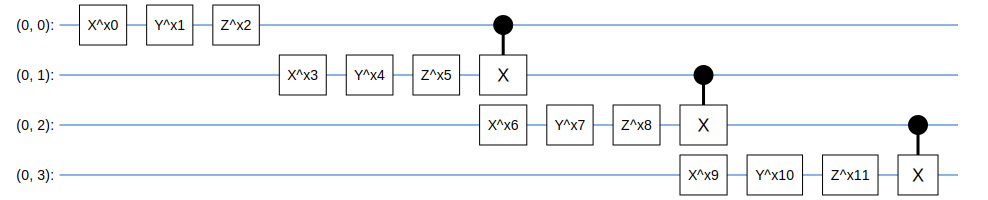

In [22]:
SVGCircuit(quantum_fc_circuit(cirq.GridQubit.rect(1, 4), sympy.symbols('x0:12')))

### PCA + Angle Encoding

#### Dimensionality Reduction: Principal Component Analysis (PCA)

Before doing PCA, we need to preprocess the data.
First, we have to flatten the images into one-dimensional vectors.

In [23]:
x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

print(x_train_flatten.shape, x_test_flatten.shape)

(100, 1024) (100, 1024)


Second, it is also better to do normalization before PCA. But upon inspection, there are some features (pixels) in the dataset that have a non-zero mean but very small standard deviation, resulting in a huge value of features after the normalization. One of the reasons this can happen is that there is not enough variation in the dataset for some features, which leads to a very small standard deviation.

So for this project, we will proceed without doing the normalization.

In [24]:
from sklearn.decomposition import PCA

num_component = 16
pca = PCA(n_components=num_component)
pca.fit(x_train_flatten)
print(np.cumsum(pca.explained_variance_ratio_))

[0.48118097 0.6593828  0.76321    0.84084564 0.89022726 0.92087126
 0.946993   0.9600858  0.96964806 0.976457   0.9819477  0.98669606
 0.99004734 0.99288285 0.9952728  0.9963434 ]


We will reduce the dataset from 1024 features to 16 features. We can see that by using only 16 features from PCA, the dataset already captures more than 99.6% of the total variance.

In [25]:
x_train_pca = pca.transform(x_train_flatten)
x_test_pca = pca.transform(x_test_flatten)

print(x_train_pca.shape, x_test_pca.shape)

(100, 16) (100, 16)


Check the minimum and maximum value of the features to see whether we need to scale them or not. Since an RY gate's argument is an angle, it is best to keep the value of the features between $-\pi$ to $\pi$.

In [26]:
print(x_train_pca.min(), x_train_pca.max())
print(x_test_pca.min(), x_test_pca.max())

-0.3767928 0.7692176
-0.599721 0.72540677


The values are all inside the boundary so no need to scale the features.

#### Generate Quantum Data from the Dataset

After PCA, we transform the data into quantum data using angle encoding.

In [27]:
def angle_encoding(X, qubits):
    """Generate quantum data from the dataset (after PCA)."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()
        # iterate through sample's features
        for bit in range(len(qubits)):
            circuit.append(cirq.ry(sample[bit])(qubits[bit]))
        
        quantum_data.append(circuit)

    return tfq.convert_to_tensor(quantum_data)

In [28]:
qubits = cirq.GridQubit.rect(1, num_component)
train_quantum_data = angle_encoding(x_train_pca, qubits)
test_quantum_data = angle_encoding(x_test_pca, qubits)

Let's plot the angle encoding circuit for the first sample in the dataset.

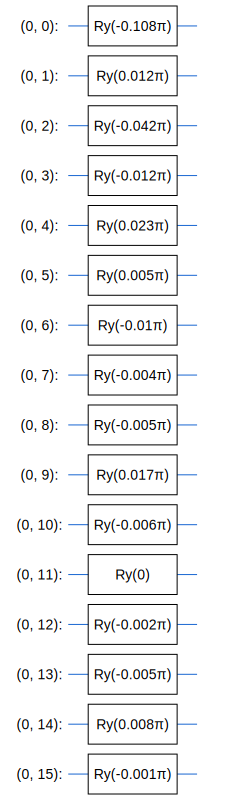

In [29]:
SVGCircuit(tfq.from_tensor(train_quantum_data)[0])

#### Model Definition

We will try two different models, with and without the Quantum Fully Connected (QFC) layer.

This first one is the one with QFC layer.

In [41]:
def model_with_qfc(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time, followed by 3 QFC layers
    """
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')

    # first convolution + pooling, reduce the number of qubit from 16 to 8
    # every conv needs 15 params
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    # every pool needs 6 params
    model_circuit += quantum_pool_circuit(qubits[:8], qubits[8:],
                                          symbols[15:21])
    
    # second convolution + pooling, reduce the number of qubit from 8 to 4
    model_circuit += quantum_conv_circuit(qubits[8:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[8:12], qubits[12:],
                                          symbols[36:42])
    
    # third convolution + pooling, reduce the number of qubit from 4 to 2
    model_circuit += quantum_conv_circuit(qubits[12:], symbols[42:57])
    model_circuit += quantum_pool_circuit(qubits[12:14], qubits[14:],
                                          symbols[57:63])
    
    # fully connected layer
    # 3 parameters for every qubit for every layer
    # repeat 3 times = 3 fully connected layer > total 18 parameters
    symbols_fc = sympy.symbols('qfc0:18')
    for i in range(3):
        model_circuit += quantum_fc_circuit(qubits[14:], symbols_fc[2*3*i : 2*3*(i+1)])
    
    # final unitary
    model_circuit += one_qubit_unitary(qubits[15], sympy.symbols('final0:3'))

    return model_circuit

Let's plot the circuit.

In [42]:
qubits = cirq.GridQubit.rect(1, num_component)
SVGCircuit(model_with_qfc(qubits))

Next, we construct a model from this circuit.

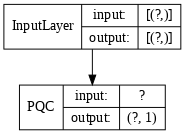

In [43]:
# Create our qubits and readout operators in Cirq.
qubits = cirq.GridQubit.rect(1, num_component)
readout_operators = cirq.Z(qubits[-1])

# Build a sequential model
image_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

quantum_model = tfq.layers.PQC(model_with_qfc(qubits),
                               readout_operators)(image_input)

qcnn_with_qfc = tf.keras.Model(inputs=[image_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_with_qfc,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

The next one is the one without QFC.

In [44]:
def model_wo_qfc(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:84')

    # first convolution + pooling, reduce the number of qubit from 16 to 8
    # every conv needs 15 params
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    # every pool needs 6 params
    model_circuit += quantum_pool_circuit(qubits[:8], qubits[8:],
                                          symbols[15:21])
    
    # second convolution + pooling, reduce the number of qubit from 8 to 4
    model_circuit += quantum_conv_circuit(qubits[8:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[8:12], qubits[12:],
                                          symbols[36:42])
    
    # third convolution + pooling, reduce the number of qubit from 4 to 2
    model_circuit += quantum_conv_circuit(qubits[12:], symbols[42:57])
    model_circuit += quantum_pool_circuit(qubits[12:14], qubits[14:],
                                          symbols[57:63])
    
    # forth convolution + pooling, reduce the number of qubit from 2 to 1
    model_circuit += quantum_conv_circuit(qubits[14:], symbols[63:78])
    model_circuit += quantum_pool_circuit([qubits[14]], [qubits[15]],
                                          symbols[78:84])

    return model_circuit

Let's plot the circuit.

In [45]:
qubits = cirq.GridQubit.rect(1, num_component)
SVGCircuit(model_wo_qfc(qubits))

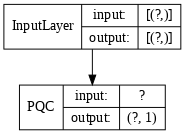

In [46]:
# Create our qubits and readout operators in Cirq.
qubits = cirq.GridQubit.rect(1, num_component)
readout_operators = cirq.Z(qubits[-1])

# Build a sequential model
image_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

quantum_model_wo = tfq.layers.PQC(model_wo_qfc(qubits),
                               readout_operators)(image_input)

qcnn_wo_qfc = tf.keras.Model(inputs=[image_input], outputs=[quantum_model_wo])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_wo_qfc,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

The two models have the same number of trainable parameters. Usually, it is considered a fair comparison between two models with different architecture if both models have the same number of trainable parameters.

In [47]:
qcnn_with_qfc.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc_2 (PQC)                  (None, 1)                 84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [48]:
qcnn_wo_qfc.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc_3 (PQC)                  (None, 1)                 84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


#### Train the Model

We need a custom accuracy function since the label now is 1/-1 instead of 1/0.

In [49]:
# Custom accuracy metric
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

The optimizer that will be used to train both models is Adam with lr = 0.001. The cost function to be minimized is MSE (same for both models).

In [50]:
# Compile the models
qcnn_with_qfc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

qcnn_wo_qfc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

Let's train the models for 100 epochs.

In [51]:
# Fit the model with QFC
history_with = qcnn_with_qfc.fit(x=train_quantum_data,
                         y=y_train,
                         batch_size=32,
                         epochs=100,
                         verbose=1,
                         validation_data=(test_quantum_data, y_test))

Epoch 1/100
4/4 [==============================] - 18s 5s/step - loss: 1.0063 - custom_accuracy: 0.4531 - val_loss: 0.9974 - val_custom_accuracy: 0.4219
Epoch 2/100
4/4 [==============================] - 18s 4s/step - loss: 1.0038 - custom_accuracy: 0.4531 - val_loss: 0.9982 - val_custom_accuracy: 0.4219
Epoch 3/100
4/4 [==============================] - 18s 4s/step - loss: 1.0020 - custom_accuracy: 0.3516 - val_loss: 0.9990 - val_custom_accuracy: 0.4766
Epoch 4/100
4/4 [==============================] - 19s 5s/step - loss: 1.0008 - custom_accuracy: 0.5000 - val_loss: 0.9997 - val_custom_accuracy: 0.4844
Epoch 5/100
4/4 [==============================] - 18s 4s/step - loss: 0.9993 - custom_accuracy: 0.4688 - val_loss: 1.0003 - val_custom_accuracy: 0.6172
Epoch 6/100
4/4 [==============================] - 18s 5s/step - loss: 0.9982 - custom_accuracy: 0.5625 - val_loss: 1.0013 - val_custom_accuracy: 0.5781
Epoch 7/100
4/4 [==============================] - 18s 5s/step - loss: 0.9968 - cu

In [53]:
# save the training history as csv file
import csv

w = csv.writer(open("./train_history_qcnn_with_qfc.csv", "w"))
for key, val in history_with.history.items():
    w.writerow([key, val])

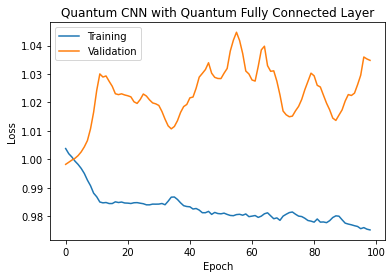

In [55]:
plt.plot(history_with.history['loss'][1:], label='Training')
plt.plot(history_with.history['val_loss'][1:], label='Validation')
plt.title('Quantum CNN with Quantum Fully Connected Layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# Fit the model without QFC
history_wo = qcnn_wo_qfc.fit(x=train_quantum_data,
                         y=y_train,
                         batch_size=32,
                         epochs=100,
                         verbose=1,
                         validation_data=(test_quantum_data, y_test))

Epoch 1/100
4/4 [==============================] - 18s 5s/step - loss: 1.0016 - custom_accuracy: 0.5625 - val_loss: 1.0028 - val_custom_accuracy: 0.5781
Epoch 2/100
4/4 [==============================] - 18s 5s/step - loss: 0.9997 - custom_accuracy: 0.5469 - val_loss: 1.0048 - val_custom_accuracy: 0.5781
Epoch 3/100
4/4 [==============================] - 18s 5s/step - loss: 0.9978 - custom_accuracy: 0.4922 - val_loss: 1.0065 - val_custom_accuracy: 0.5781
Epoch 4/100
4/4 [==============================] - 18s 5s/step - loss: 0.9961 - custom_accuracy: 0.5469 - val_loss: 1.0069 - val_custom_accuracy: 0.5781
Epoch 5/100
4/4 [==============================] - 18s 5s/step - loss: 0.9957 - custom_accuracy: 0.5469 - val_loss: 1.0080 - val_custom_accuracy: 0.5781
Epoch 6/100
4/4 [==============================] - 18s 5s/step - loss: 0.9943 - custom_accuracy: 0.5469 - val_loss: 1.0091 - val_custom_accuracy: 0.5781
Epoch 7/100
4/4 [==============================] - 18s 5s/step - loss: 0.9928 - cu

In [67]:
# save the training history as csv file
import csv

w = csv.writer(open("./train_history_qcnn_wo_qfc.csv", "w"))
for key, val in history_wo.history.items():
    w.writerow([key, val])

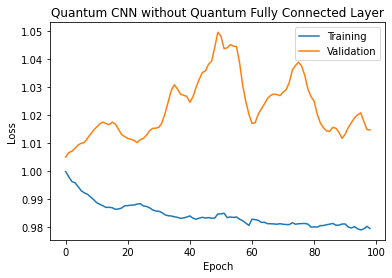

In [58]:
plt.plot(history_wo.history['loss'][1:], label='Training')
plt.plot(history_wo.history['val_loss'][1:], label='Validation')
plt.title('Quantum CNN without Quantum Fully Connected Layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now we compare the models by plotting the loss and accuracy during training.

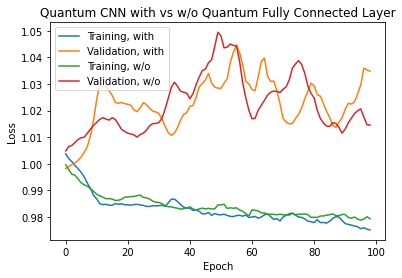

In [60]:
plt.plot(history_with.history['loss'][1:], label='Training, with')
plt.plot(history_with.history['val_loss'][1:], label='Validation, with')
plt.plot(history_wo.history['loss'][1:], label='Training, w/o')
plt.plot(history_wo.history['val_loss'][1:], label='Validation, w/o')

plt.title('Quantum CNN with vs w/o Quantum Fully Connected Layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

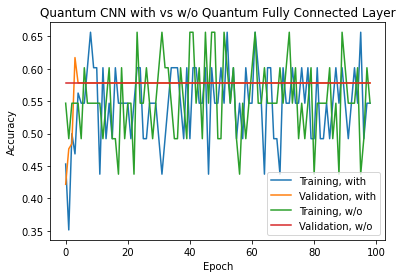

In [61]:
plt.plot(history_with.history['custom_accuracy'][1:], label='Training, with')
plt.plot(history_with.history['val_custom_accuracy'][1:], label='Validation, with')
plt.plot(history_wo.history['custom_accuracy'][1:], label='Training, w/o')
plt.plot(history_wo.history['val_custom_accuracy'][1:], label='Validation, w/o')

plt.title('Quantum CNN with vs w/o Quantum Fully Connected Layer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From these plots, we can clearly see that:

1. Both models fit the training dataset with the training losses decrease over time.
2. Both models overfit to the training dataset. As expected, 100 training samples are too small for the models to generalize well.
3. Both models stuck at around 0.55 (average) of accuracy and cannot get better (averaging into flat curve).
4. The model with QFC shows a little bit better in performance (lower loss) at around after 90 epochs.

Because the model with QFC seems to be better, I trained it with more epochs (up to 200 epochs). But this time, I prepend the quantum data with a cluster state circuit like in the TFQ tutorial.

In [ ]:
# Create our qubits and readout operators in Cirq.
qubits = cirq.GridQubit.rect(1, num_component)
readout_operators = cirq.Z(qubits[-1])

# Build a sequential model
image_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    image_input, prepend=cluster_state_circuit(qubits))

quantum_model = tfq.layers.PQC(model_with_qfc(qubits),
                               readout_operators)(cluster_state)

qcnn_with_qfc_cluster = tf.keras.Model(inputs=[image_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_with_qfc_cluster,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [ ]:
# Fit the model with QFC and cluster state circuit
history = qcnn_with_qfc_cluster.fit(x=train_quantum_data,
                                    y=y_train,
                                    batch_size=32,
                                    epochs=100,
                                    verbose=1,
                                    validation_data=(test_quantum_data, y_test))

This is the results from the best model that I have achieved so far.

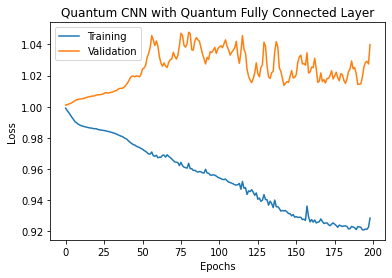

In [ ]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')


plt.title('Quantum CNN with Quantum Fully Connected Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

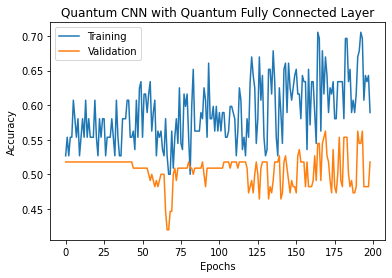

In [ ]:
plt.plot(history.history['custom_accuracy'][1:], label='Training')
plt.plot(history.history['val_custom_accuracy'][1:], label='Validation')
plt.title('Quantum CNN with Quantum Fully Connected Layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the plots, it can be seen that:

1. The model performs better with the cluster state circuit as the training loss is lower.
2. The model still overfits the training data since the validation loss still did not get better.
3. The training accuracy is slightly higher (averaging at 0.6 to 0.65) and shows an uptrend.

These results are very interesting as it shows that the cluster state helps the model to perform better. It seems that the translationally invariant and high entanglement aspect of the cluster state does help.

### Amplitude Encoding

This code below is the implementation of amplitude encoding in Cirq.

In [64]:
# helper function

# function to calculate the angle β
def beta(s, j, X_sample):
    # numerator index
    index_num = (2*j-1)*(2**(s-1))
    # denominator index
    index_den = (j-1)*(2**s)
    
    num = np.sqrt(np.sum(abs(X_sample[index_num : index_num+2**(s-1)])**2))
    den = np.sqrt(np.sum(abs(X_sample[index_den : index_den+2**(s)])**2))
    
    if den == 0:
        #print("Zero denominator!")
        beta = 0
    else:
        beta = 2*np.arcsin(num/(den+1e-10))
    
    return beta

def decimalToBinary(n, length):
    binary = bin(n).replace("0b", "")
    if len(binary) != length:
        for i in range(length - len(binary)):
            binary = "0" + binary
    
    return binary

def locate_x(current_j, prev_j, length):
    loc = []
    
    prev_binary = decimalToBinary(prev_j, length)
    counter = 0
    
    for i in decimalToBinary(current_j, length):
        if i != prev_binary[counter]:
            loc.append(counter)
        counter += 1
    
    return loc

In [65]:
def mcry_gate(qubits, i, theta):
    control = [c for c in range(i)]
    target = i

    mult_cnot_qubit = len(control + [target])
    unitary_matrix = np.zeros((2**mult_cnot_qubit, 2**mult_cnot_qubit))
    np.fill_diagonal(unitary_matrix, val=1)
    unitary_matrix[-1, :] *= 0
    unitary_matrix[-1, -2] += 1
    unitary_matrix[-2, :] *= 0
    unitary_matrix[-2, -1] += 1

    mcry = cirq.Circuit()

    mcry += cirq.rx(np.pi/2)(qubits[target])
    mcry += cirq.rz(theta/2)(qubits[target])
    mcry += cirq.rx(-np.pi/2)(qubits[target])

    # MCCNOT
    mcry += cirq.ops.MatrixGate(unitary_matrix).on(*qubits)

    mcry += cirq.rx(np.pi/2)(qubits[target])
    mcry += cirq.rz(-theta/2)(qubits[target])
    mcry += cirq.rx(-np.pi/2)(qubits[target])

    # MCCNOT
    mcry += cirq.ops.MatrixGate(unitary_matrix).on(*qubits)

    return mcry

In [66]:
def amplitude_encoding(X_sample):

    n = int(np.log2(len(X_sample)))
    qubits = cirq.GridQubit.rect(1, n)

    circuit = cirq.Circuit()

    # for every qubits
    for i in range(n):
        # for every gates on the qubit
        if i == 0:
            circuit += cirq.ry(beta(n, 1, X_sample))(qubits[0])
        else:
            for j in range(2**i):
                if j != 0:
                    for loc in locate_x((2**i)-j-1, (2**i)-j, length=i):
                        circuit += cirq.X(qubits[loc])

                mcry_qubit = [qubits[c] for c in range(i+1)]

                #circuit += mcry_gate(mcry_qubit, i, beta(n-i, (2**i)-j, X_sample))
                circuit += cirq.ControlledGate(sub_gate=cirq.ry(beta(n-i, (2**i)-j, X_sample)), num_controls=len(mcry_qubit)-1)(*mcry_qubit)

            for k in range(i):
                circuit += cirq.X(qubits[k])

    return circuit

Let's test out the code and see the measurement result.

In [ ]:
# example of an already normalized feature vector
X_sample = np.array([np.sqrt(0.2), np.sqrt(0.2), np.sqrt(0.5), np.sqrt(0.1)])

qubits = cirq.GridQubit.rect(1, 2)
a = amplitude_encoding(X_sample)
a += cirq.measure(*qubits, key='result')

# Initialize simulator
s=cirq.Simulator()
# Sample the circuit with 10000 shots
samples=s.run(a, repetitions=10000)
samples.histogram(key="result")

Counter({0: 2050, 1: 2002, 2: 4987, 3: 961})

We can see that the quantum state's amplitudes exactly matched the features' value as the measurement results (per total shots) are equal to the feature vector squared (remember that measurement results are equal to the square of amplitudes).

#### Generate Quantum Data from the Dataset

An attempt to use the amplitude encoding.

In [ ]:
def amplitude_encoding_generate(X):
    """Generate quantum data from the dataset (after PCA)."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        quantum_data.append(amplitude_encoding(sample))

    return tfq.convert_to_tensor(quantum_data)

Normalize all samples' feature vectors to conform with the amplitude encoding equation mentioned in the **The Approach Used to Tackle the Problem** section.

In [ ]:
x_train_norm = (x_train_pca.T / np.sqrt(np.sum(x_train_pca ** 2, -1))).T
x_test_norm = (x_test_pca.T / np.sqrt(np.sum(x_test_pca ** 2, -1))).T

In [ ]:
tfq.convert_to_tensor([amplitude_encoding(x_train_norm[47])])

ValueError: ignored

tfq.convert_to_tensor failed to convert the multi-controlled RY gate.

In [ ]:
qubits_test = cirq.GridQubit.rect(1, 3)
circ = cirq.Circuit()
circ += cirq.ControlledGate(sub_gate=cirq.X, num_controls=2)(*qubits_test)
print(circ)

(0, 0): ───@───
           │
(0, 1): ───@───
           │
(0, 2): ───X───


It also failed to convert the CCH gate.

In [ ]:
tfq.convert_to_tensor([circ])

ValueError: ignored

Until the time of submission, the workaround for this problem is still not known yet.

## Conclusion

A QCNN model with and without the QFC layer has been trained. Both models were able to fit the training dataset as the training loss decrease over time. Both models did not generalize well as the validation loss did not decrease. This is to be expected since the training dataset is too small. The QCNN model with the QFC layer shows a slightly better performance with lower loss. It is also found that the cluster state does help the QCNN model in achieving better performance (lower loss, higher accuracy).

For future work, the workaround to make the amplitude encoding method works needs to be found. It is one of the promising encoding methods for data with a large number of features (e.g., image) as it only needs $\operatorname{log_{2}}(N)$ qubits where $N$ is the number of features.

## References

1. [Y. LeCun and C. Cortes, “MNIST handwritten digit database,” 2010.](http://yann.lecun.com/exdb/mnist/)
2. [E. Farhi and H. Neven, “Classification with Quantum Neural Networks on Near Term Processors,” pp. 1–21, 2018.](https://arxiv.org/abs/1802.06002)
3. [A. Skolik, J. R. McClean, M. Mohseni, P. van der Smagt, and M. Leib, “Layerwise learning for quantum neural networks,” Quantum Mach. Intell., vol. 3, no. 1, p. 5, Jun. 2021.](https://link.springer.com/article/10.1007/s42484-020-00036-4)
4. [S. Mardirosian, “Quantum-enhanced Supervised Learning with Variational Quantum Circuits,” Leiden University, 2019.](https://theses.liacs.nl/pdf/2018-2019-MardirosianSevak.pdf)
5. [M. Mottonen, J. J. Vartiainen, V. Bergholm, and M. M. Salomaa, “Transformation of quantum states using uniformly controlled rotations,” Quantum Inf. Comput., vol. 5, no. 6, pp. 467–473, Jul. 2004.](https://dl.acm.org/doi/abs/10.5555/2011670.2011675)
6. [M. Schuld and F. Petruccione, Supervised Learning with Quantum Computers. 2018.](https://link.springer.com/book/10.1007/978-3-319-96424-9)
7. [I. Cong, S. Choi, and M. D. Lukin, “Quantum convolutional neural networks,” Nat. Phys., vol. 15, no. 12, pp. 1273–1278, Dec. 2019.](https://www.nature.com/articles/s41567-019-0648-8)